# Final Project Deep Learning Bootcamp 
# Cats vs Dogs Classification
<b> Author: Agnes Lei, Amelia Budiharto, Fathimah Abdul Rahman, Hossam Fahmy</b> 

The challenge is to classify images into two classes: dogs and cats. We use various deep learning approach to tackle this challenge.

In the beginning we tested basic convolutional model with data augmententation, hyperparameter fine tuning and K-fold cross validation. As a next step we try various models like AutoKeras, Transfer Learning and PyTorch ResNnet18 in order to compare model performance and get the best accuracy through experimenting & tuning different model parameters. The best model was AutoKeras model with test accuracy of 91%.

<h1>Table of Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Learning-Bootcamp---Final Project: Cats-vs-Dogs-Classification" data-toc-modified-id="Deep-Learning-in-vision---Cats-vs-Dogs-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Final Project: Cats-vs-Dogs-Classification</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Dataset</a></span></li><li><span><a href="#Load-Images" data-toc-modified-id="Load-Images-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Split Dataset</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Basic-Model" data-toc-modified-id="Basic-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Basic CNN Model</a></span></li><li><span><a href="#Model-with-data-augmentation" data-toc-modified-id="Model-with-data-augmentation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Basic CNN with model fine-tuning</a></span></li><li><span><a href="#With-batch-normalisation-and-dropout" data-toc-modified-id="With-batch-normalisation-and-dropout-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>AutoKeras Model</a></span></li><li><span><a href="#Different-Activation-Function---ELU" data-toc-modified-id="Different-Activation-Function---ELU-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Transfer Learning Model</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>PyTorch ResNet18 Model</a></span></li></ul></li><li><span><a href="#Test-Set---Transfer-Learning-Model" data-toc-modified-id="Test-Set---Transfer-Learning-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Final Best Model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Take-a-look-inside-the-black-box" data-toc-modified-id="Take-a-look-inside-the-black-box-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Future Improvement</a></span><ul class="toc-item"></ul></li></ul></div>

In [67]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
from keras import layers
from keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten, BatchNormalization

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

import glob
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/DeepLearningBootcamp/Final Project

/content/drive/My Drive/Colab Notebooks/DeepLearningBootcamp/Final Project


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Load Dataset

In [ ]:
TRAINING_IMAGE_FOLDER_PATH = "./training_data"

FILE_NAMES = os.listdir(TRAINING_IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

In [ ]:
targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(TRAINING_IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

In [ ]:
dataset.head(10)

,image_path,target
0,./training_data/dog.2141.jpg,dog
1,./training_data/cat.4099.jpg,cat
2,./training_data/dog.7011.jpg,dog
3,./training_data/cat.11342.jpg,cat
4,./training_data/cat.12461.jpg,cat
5,./training_data/dog.7039.jpg,dog
6,./training_data/dog.3935.jpg,dog
7,./training_data/dog.11967.jpg,dog
8,./training_data/cat.7792.jpg,cat
9,./training_data/cat.268.jpg,cat


In [ ]:
target_counts=dataset['target'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['dog']))
print("Number of cats in the dataset:{}".format(target_counts['cat']))

Number of dogs in the dataset:1405
Number of cats in the dataset:1502


In [ ]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    for path, target in zip(full_paths, targets):
        if target!=show and show!="both":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(WIDTH,HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

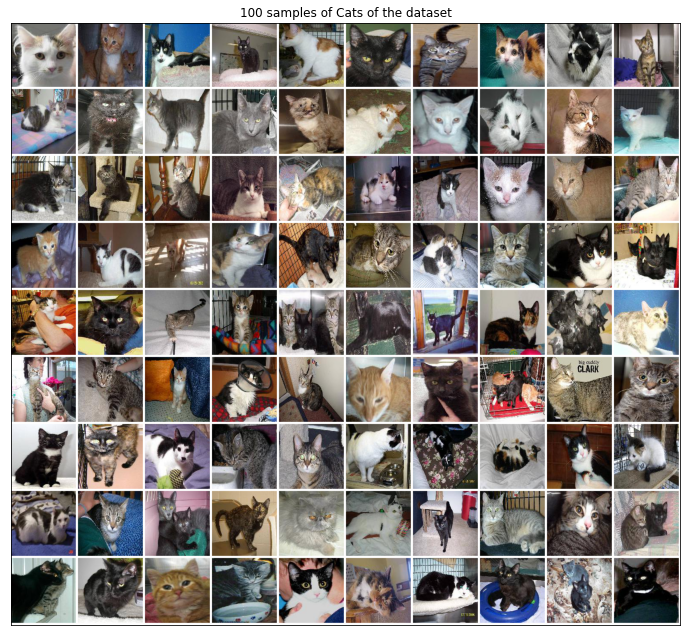

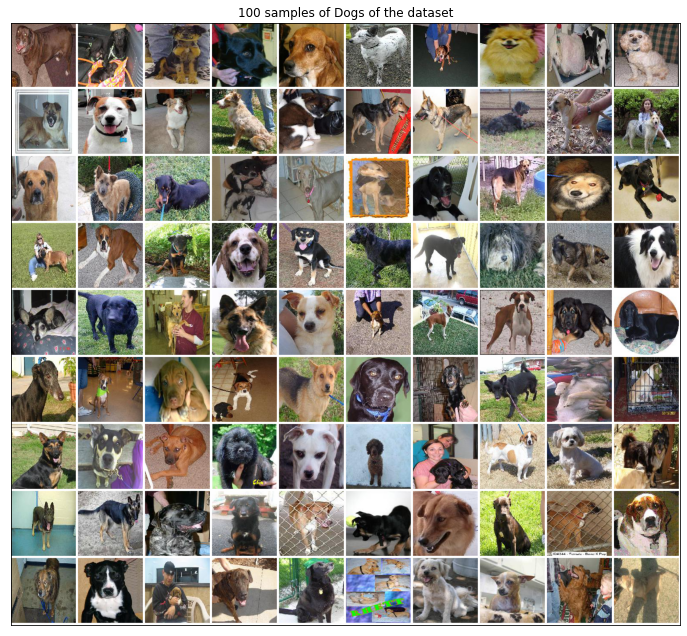

In [ ]:
show_gallery(show="cat")
show_gallery(show="dog")

## Split dataset
The training_data was splitted into training and validation set. While the validation_data used as the test set.

In [ ]:
# The training_data split 80/20 for training and validation

dataset_train, dataset_validation = train_test_split(dataset,
                                                 test_size=0.2,
                                                 random_state=42)

In [ ]:
train_datagen=ImageDataGenerator(
rotation_range=40,
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.2,
height_shift_range=0.2)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe = dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 2325 validated image filenames belonging to 2 classes.


In [ ]:
val_datagen=ImageDataGenerator(rescale=1./255)
val_datagenerator=val_datagen.flow_from_dataframe(dataframe = dataset_validation,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 582 validated image filenames belonging to 2 classes.


# Modeling


### Basic CNN Model
The base model use 4 convolutional layers with 1 dense layer and flatten layer. This model is an indicator to check the performance of the basic neural network model that can be achieved without much refinement. Using 50 epochs, the model can only achieve 74% of accuracy. As you seen on the graph, the model is not stable. Epoch over epoch, the accuracy and loss value can fluctuated very fast.

In [ ]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validatin Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validatin Accuracy"]=modelHistory.history['val_accuracy']
  
    history.plot(figsize=(12,8))
    plt.title(" Convolutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

In [ ]:
# Construct base CNN model

baseCNN_model = models.Sequential()
baseCNN_model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape=(WIDTH, HEIGHT, 3), activation='relu'))
baseCNN_model.add(layers.MaxPooling2D(pool_size=2))
baseCNN_model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
baseCNN_model.add(layers.MaxPooling2D(pool_size=2))
baseCNN_model.add(layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'))
baseCNN_model.add(layers.MaxPooling2D(pool_size=2))
baseCNN_model.add(layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'))
baseCNN_model.add(layers.MaxPooling2D(pool_size=2))

baseCNN_model.add(layers.Flatten())
baseCNN_model.add(layers.Dense(512, activation='relu'))

baseCNN_model.add(layers.Dense(1, activation='sigmoid'))

baseCNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
baseCNN_model.compile(loss="binary_crossentropy", 
             optimizer=optimizers.RMSprop(lr=0.001),
             metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Train model

baseCNN_model_history = baseCNN_model.fit(train_datagenerator,
                                epochs=50,
                                validation_data=val_datagenerator
                                # validation_steps=dataset_test.shape[0]//150,
                                # steps_per_epoch=dataset_train.shape[0]//150
                                )

Epoch 1/50
16/16 [==============================] - 29s 982ms/step - loss: 0.7948 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.6922 - accuracy: 0.5355 - val_loss: 0.6858 - val_accuracy: 0.5601
Epoch 3/50
16/16 [==============================] - 16s 976ms/step - loss: 0.6807 - accuracy: 0.5776 - val_loss: 0.6870 - val_accuracy: 0.5636
Epoch 4/50
16/16 [==============================] - 16s 978ms/step - loss: 0.6881 - accuracy: 0.5544 - val_loss: 0.6772 - val_accuracy: 0.5808
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.6942 - accuracy: 0.5535 - val_loss: 0.6791 - val_accuracy: 0.5842
Epoch 6/50
16/16 [==============================] - 16s 988ms/step - loss: 0.6785 - accuracy: 0.5656 - val_loss: 0.6598 - val_accuracy: 0.6495
Epoch 7/50
16/16 [==============================] - 16s 974ms/step - loss: 0.6825 - accuracy: 0.5677 - val_loss: 0.6727 - val_accuracy: 0.6082
Epoch

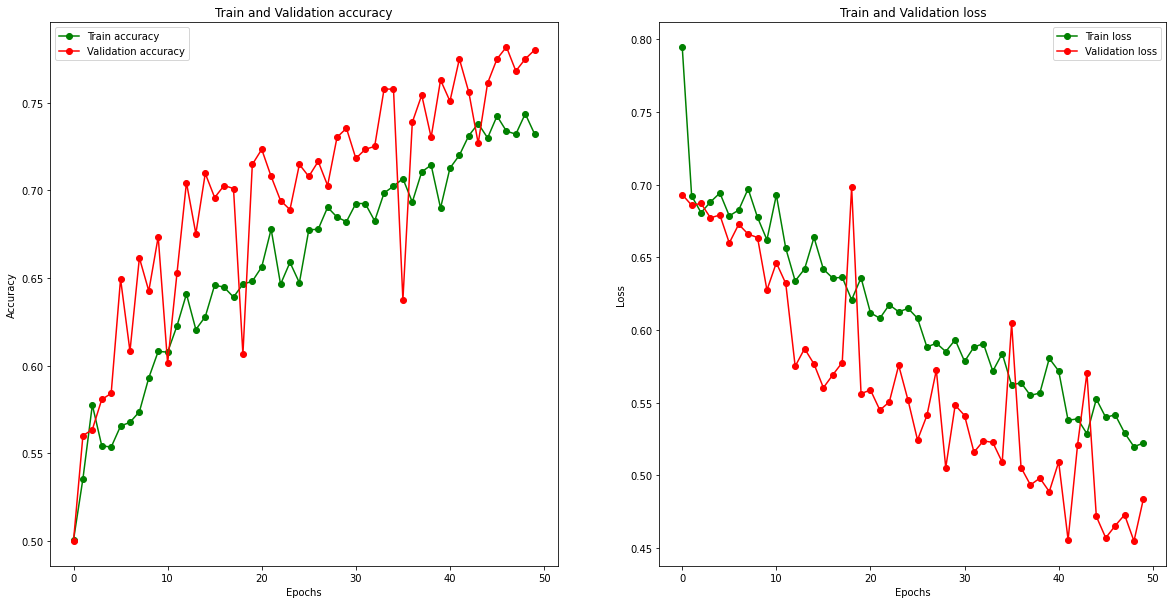

In [ ]:
# Plot the train accuracy and loss

epochs = [i for i in range(50)]

fig, ax = plt.subplots(1, 2)
train_acc = baseCNN_model_history.history["accuracy"]
train_loss = baseCNN_model_history.history["loss"]
val_acc = baseCNN_model_history.history["val_accuracy"]
val_loss = baseCNN_model_history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
# save the model to file
baseCNN_model.save('Classification_baseCNN_model.h5')

### Basic CNN with model fine-tuning
As a next step, we will fine tune the prior model since it is clearly does not give a satisfying accuracy. Following are several steps that taken to fine tune the base CNN model:

<u>1. Data Augmentation </u>

This method used to increase the training data. Using the original image in the train dataset, we multiply and make adjustment that looks different from the original one which called as data augmentation. With the data augmentation, we adjust the original image through: horizontally flip, rotate to other angle, zoom image.

<u>2. Batch Normalisation </u>  
Using batch normalization, the model trained with mini-batches instead of the full data set. It serves to speed up training and use higher learning rates.

<u>3. Dropout Layers </u>    
Dropout is a regularization technique that prevents neural networks from overfitting. It's randomly sekect and drop neuron during training. 

<u>4. Change Activation Layers </u>   
We tried several activation function: RELU, ELU, Leaky RELU. As going into trial and error, ELU was found to bring best result.

<u>5. Learning Rate Reduction </u> 
In order to reduce overfitting, we add the learning rate callback reduction. Therefore, the validation accuracy do not go beyond the train accuracy.

As a conclusion, the second model able to improve the accuracy to 88% and there is no indication of overfitting. Although it already did tremendous improvement from the base model, we are still aiming for better accuracy.

In [ ]:
# Data augmentation

data_augmentation = models.Sequential(
  [layers.RandomFlip("horizontal",input_shape=(WIDTH,HEIGHT, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

In [ ]:
# Construct the fine tune CNN model

finetuneCNN_model = models.Sequential()
data_augmentation
finetuneCNN_model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape=(WIDTH, HEIGHT, 3), activation='elu'))
finetuneCNN_model.add(BatchNormalization())
finetuneCNN_model.add(layers.MaxPooling2D(pool_size=2))
# finetuneCNN_model.add(Dropout(0.25))

finetuneCNN_model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'elu'))
finetuneCNN_model.add(BatchNormalization())
finetuneCNN_model.add(layers.MaxPooling2D(pool_size=2))
# finetuneCNN_model.add(Dropout(0.25))

finetuneCNN_model.add(layers.Conv2D(128, kernel_size=(3,3), activation = 'elu'))
finetuneCNN_model.add(BatchNormalization())
finetuneCNN_model.add(layers.MaxPooling2D(pool_size=2))
# finetuneCNN_model.add(Dropout(0.25))

finetuneCNN_model.add(layers.Conv2D(128, kernel_size=(3,3), activation = 'elu'))
finetuneCNN_model.add(BatchNormalization())
finetuneCNN_model.add(layers.MaxPooling2D(pool_size=2))
finetuneCNN_model.add(Dropout(0.25))

finetuneCNN_model.add(layers.Flatten())
finetuneCNN_model.add(layers.Dense(512, activation='elu'))
finetuneCNN_model.add(Dense(512,activation='elu'))
finetuneCNN_model.add(BatchNormalization())
finetuneCNN_model.add(Dropout(0.25))

finetuneCNN_model.add(layers.Dense(1, activation='sigmoid'))

finetuneCNN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 148, 148, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
finetuneCNN_model.compile(loss="binary_crossentropy", 
             optimizer=optimizers.RMSprop(lr=0.001),
             metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Adding learning rate reduction 

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.2,min_lr = 0.001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
# Train model

finetuneCNN_model_history = finetuneCNN_model.fit(train_datagenerator,
                                epochs=50,
                                validation_data=val_datagenerator,
                                callbacks=[earlystop,learning_rate_reduction]
                                # validation_steps=dataset_validation.shape[0]//15,
                                # steps_per_epoch=dataset_train.shape[0]//15
                                )

Epoch 1/50
16/16 [==============================] - 18s 1s/step - loss: 0.7559 - accuracy: 0.5815 - val_loss: 1.0361 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 16s 999ms/step - loss: 0.6159 - accuracy: 0.6692 - val_loss: 0.7249 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.6063 - accuracy: 0.6852 - val_loss: 0.6066 - val_accuracy: 0.6753 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 16s 1s/step - loss: 0.6060 - accuracy: 0.6822 - val_loss: 0.6788 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 16s 1s/step - loss: 0.5831 - accuracy: 0.6976 - val_loss: 0.5984 - val_accuracy: 0.6838 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 16s 998ms/step - loss: 0.5940 - accuracy: 0.6981 - val_loss: 0.5813 - val_accuracy: 0.6821 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 16s 996ms/step - loss: 0

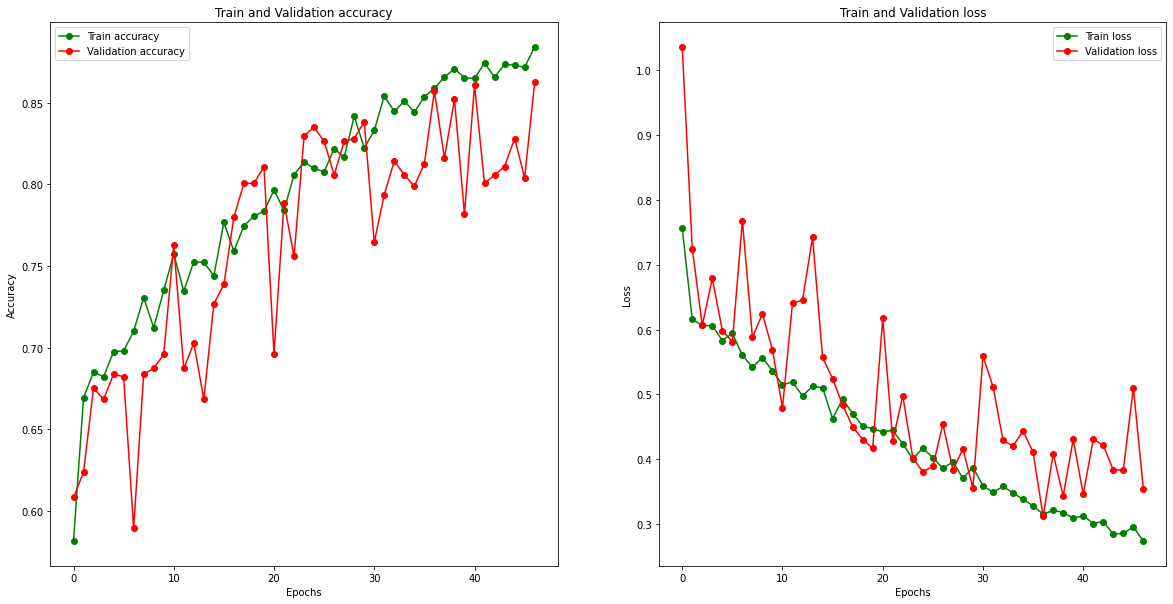

In [ ]:
# Plot the train accuracy and loss

epochs = [i for i in range(47)]

fig, ax = plt.subplots(1, 2)
train_acc = finetuneCNN_model_history.history["accuracy"]
train_loss = finetuneCNN_model_history.history["loss"]
val_acc = finetuneCNN_model_history.history["val_accuracy"]
val_loss = finetuneCNN_model_history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
# save the model to file
finetuneCNN_model.save('Classification_finetuneCNN_model2.h5')

### AutoKeras Model
AutoKeras is a build in function from keras tensorflow that provide assistance to find best model and parameter. We train and find the best model with 50 trials and 5 epochs per iteration. It takes more than 8 hours to run the autokeras automate search in order to find the best model.

The best AutoKeras model has 0.97 val_accuracy and 0.065 val_loss. There is no indication of overfitting with autokeras model.

We did sanity check by re-predicting the full train dataset using the AutoKeras best model and to check the accuracy metrics. It gives 0.91 prediction accuracy which a bit lower compare to the accuracy during the training.

In [ ]:
# !pip install autokeras

In [69]:
from PIL import Image

def img_preprocess(img): 
  """
  Opens the image and does some preprocessing 
  such as converting to RGB, resize and converting to array
  """
  img = Image.open(img)
  # img = img.convert('RGB')
  # img = img.resize((256,256))
  # img = np.asarray(img)/255
  img = np.asarray(img)
  return img


In [ ]:
from autokeras import ImageClassifier

x = np.array([img_preprocess(p) for p in dataset['image_path'].values]) 
label = dataset['target']
label = np.array(label)
y = (label == 'cat').astype(int)

In [ ]:
print(np.array(img_preprocess(dataset['image_path'][1])).shape)
# dataset['image_path'][1]
# x

(150, 150, 3)


In [ ]:
# autokeras
model = ImageClassifier(
    max_trials = 50, 
    loss = 'binary_crossentropy',
    metrics = 'accuracy' )

model.fit(x = x, y = y, epochs = 5, validation_split = 0.2)

Trial 54 Complete [00h 29m 56s]
val_loss: 0.7126836776733398

Best val_loss So Far: 0.06571194529533386
Total elapsed time: 07h 54m 07s
Epoch 1/5
Not enough memory, reduce batch size to 16.
Epoch 1/5
Not enough memory, reduce batch size to 8.
Epoch 1/5
Not enough memory, reduce batch size to 4.
Epoch 1/5
Not enough memory, reduce batch size to 2.
Epoch 1/5
Not enough memory, reduce batch size to 1.
Epoch 1/5
2907/2907 [==============================] - 391s 135ms/step - loss: 0.4368 - accuracy: 0.7836
Epoch 2/5
2907/2907 [==============================] - 391s 134ms/step - loss: 0.1770 - accuracy: 0.9357
Epoch 3/5
2907/2907 [==============================] - 391s 134ms/step - loss: 0.1285 - accuracy: 0.9508
Epoch 4/5
2907/2907 [==============================] - 391s 135ms/step - loss: 0.0735 - accuracy: 0.9739
Epoch 5/5
2907/2907 [==============================] - 391s 135ms/step - loss: 0.0649 - accuracy: 0.9773


In [ ]:
# Export as a Keras Model
autokeras_model = model.export_model()
autokeras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 150, 150, 3)      0         
 t32)                                                            
                                                                 
 random_translation (RandomT  (None, 150, 150, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                             

In [ ]:
# save the model to file

try:
    autokeras_model.save("Classification_autokeras_model", save_format="tf")
except Exception:
    autokeras_model.save("Classification_autokeras_model.h5")


For sanity check, we reload the best model and try to predict the train set one more time and check the evaluation metrics. We got the accuracy score for more than 90%.

In [ ]:
from tensorflow.keras.models import load_model

autokeras_best_model = load_model('Classification_autokeras_model.h5', custom_objects =autokeras.CUSTOM_OBJECTS)

In [ ]:
# Try in Train model

y_pred = autokeras_best_model.predict(x)
y_pred = [round(y[0],0) for y in y_pred]
print("accuracy  = ", accuracy_score(y, y_pred))
print("recall    = ", recall_score(y, y_pred))
print("precision = ", precision_score(y, y_pred))
print("f1 score  = ", f1_score(y, y_pred))

accuracy  =  0.9054007567939456
recall    =  0.9993342210386151
precision =  0.8456338028169014
f1 score  =  0.9160817821177907


### Transfer Learning
Here section onwards, we use various pretrained model that build with deeper neural architecture and trained on bigger datasets. We use VGG16, MobileNetV2. , InceptionV3 from keras as the base layer of our model and on top of it we add further training layer.

#### Tensorflow Keras VGG16
VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date.

On top of VGG16, we added new architecture neural layer, dropout, and batch normalization. As a result, we reach 91% validation accuracy. Unfortunately, this model was overfitting since the validation accuracy exceeding the training accuracy.

In [ ]:
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense,Dropout
from keras.layers import Flatten, BatchNormalization
from keras.backend import pool2d
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

In [ ]:
# Unload the VGG16 pre-trained model

base_model = VGG16(input_shape = (WIDTH, HEIGHT, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')
base_model.trainable=False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Construct new layers on top of the pre-trained model

def define_model():
  
  # load model2
	model = VGG16(include_top=False, input_shape=(WIDTH, HEIGHT, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	finetune_model = Flatten()(model.layers[-1].output)
	finetune_model = Dense(128, activation='relu', kernel_initializer='he_uniform')(finetune_model)
	finetune_model = BatchNormalization()(finetune_model)
	finetune_model = Dropout(rate=0.25)(finetune_model)
 
	finetune_model = Dense(64, activation='relu', kernel_initializer='he_uniform')(finetune_model)
	finetune_model = BatchNormalization()(finetune_model)
	finetune_model = Dropout(rate=0.25)(finetune_model)
 
	finetune_model = Dense(1, activation='sigmoid')(finetune_model)
	# define new model
	model = Model(inputs=model.inputs, outputs=finetune_model)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

VGG16_model = define_model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Adding learning rate reduction 

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.2,min_lr = 0.001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
# Train model

VGG16_model_history = VGG16_model.fit(
    train_datagenerator, 
    epochs=50,
    validation_data=val_datagenerator,
    # validation_steps=dataset_validation.shape[0]//128,
    # steps_per_epoch=dataset_train.shape[0]//128,
    callbacks=[earlystop,learning_rate_reduction],
    verbose=1
)

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 0.7851 - accuracy: 0.6056 - val_loss: 0.6189 - val_accuracy: 0.5997 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 15s 963ms/step - loss: 0.6288 - accuracy: 0.7015 - val_loss: 0.5909 - val_accuracy: 0.6478 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 16s 977ms/step - loss: 0.5299 - accuracy: 0.7419 - val_loss: 0.5080 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 15s 994ms/step - loss: 0.4963 - accuracy: 0.7643 - val_loss: 0.4441 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 16s 978ms/step - loss: 0.4543 - accuracy: 0.7802 - val_loss: 0.4116 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 16s 978ms/step - loss: 0.4527 - accuracy: 0.7832 - val_loss: 0.3952 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 16s 967ms/step 

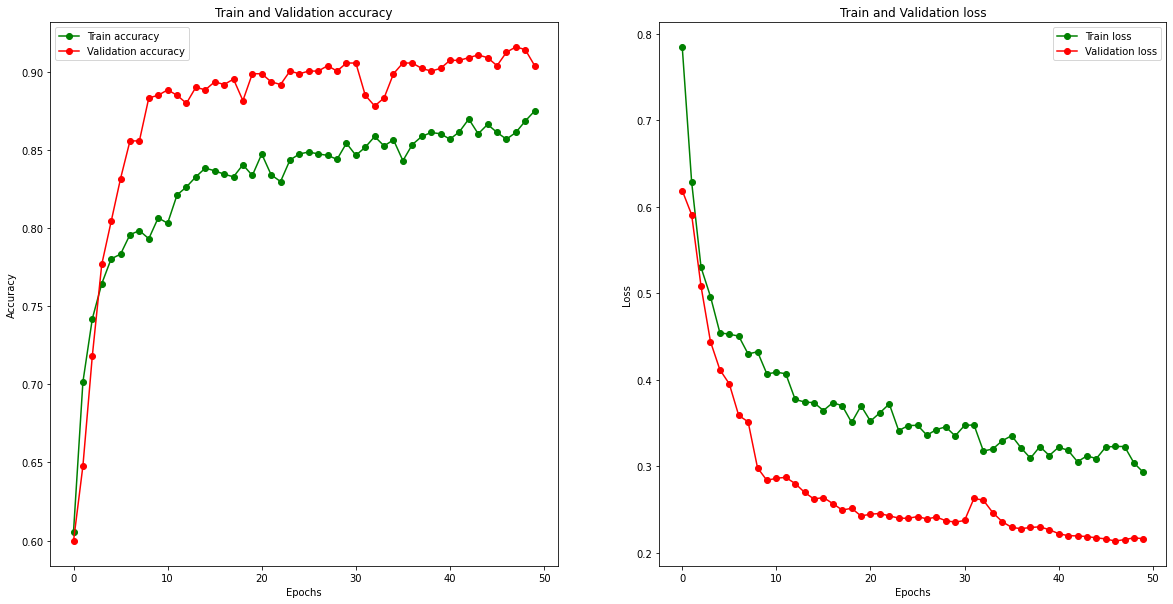

In [ ]:
# Plot the train accuracy and loss

epochs = [i for i in range(50)]

fig, ax = plt.subplots(1, 2)
train_acc = VGG16_model_history.history["accuracy"]
train_loss = VGG16_model_history.history["loss"]
val_acc = VGG16_model_history.history["val_accuracy"]
val_loss = VGG16_model_history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
# save the model to file
VGG16_model.save('Classification_kerasVGC16_model4.h5')

#### Tensorflow Keras InceptionV3
Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet.
<br>

When training and validating the model, the results seem to be good with an accuracy of 95.36%. Unfortunately, when tested with the test data, the preformance drops drastically to an accuracy of 50.76%.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Unload the InceptionV3 pre-trained model

base_model = InceptionV3(input_shape=(WIDTH, HEIGHT, 3),
                                weights="imagenet",
                                include_top=False)

# Making all the layers in pretrained model nontrainable
# Freezing all the layers of pretrained model
for layer in base_model.layers:
  layer.trainable = False
  
# Summary of the Model
base_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [ ]:
last_layer = base_model.get_layer("mixed9")
print(f"The shape of last output layer is {last_layer.output_shape}")
last_output = last_layer.output

The shape of last output layer is (None, 3, 3, 2048)


In [ ]:
# Build Callbacks 
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > 0.99):
      print("\nReached 99% accurcy, execution stopped!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Process the Model

# Flatten the output layer of pretrained model into 1 dimension
x = tensorflow.keras.layers.Flatten()(last_output)
# Add fully connected layer with relu activation
x = tensorflow.keras.layers.Dense(units=1024, activation="relu")(x)
# Add dropout with rate 0.2
x = tensorflow.keras.layers.Dropout(0.2)(x)
# Add final sigmoid layer for activation
x = tensorflow.keras.layers.Dense(1, activation="sigmoid")(x)

# Prepare the final Model
InceptionV3_model = Model(base_model.inputs, x)

In [ ]:
# Compile the Model
InceptionV3_model.compile(loss="binary_crossentropy",
                        optimizer=RMSprop(lr=0.0001),
                        metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
InceptionV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
#Train Model
InceptionV3_history = InceptionV3_model.fit(
                                            train_datagenerator,
                                            epochs=50,
                                            validation_data=val_datagenerator,
                                            callbacks=[callbacks],
                                            verbose=2
                                        )

Epoch 1/50
16/16 - 36s - loss: 0.3741 - accuracy: 0.8396 - val_loss: 0.1301 - val_accuracy: 0.9347 - 36s/epoch - 2s/step
Epoch 2/50
16/16 - 16s - loss: 0.1513 - accuracy: 0.9419 - val_loss: 0.1124 - val_accuracy: 0.9536 - 16s/epoch - 1s/step
Epoch 3/50
16/16 - 18s - loss: 0.2049 - accuracy: 0.9140 - val_loss: 0.1310 - val_accuracy: 0.9416 - 18s/epoch - 1s/step
Epoch 4/50
16/16 - 17s - loss: 0.1469 - accuracy: 0.9372 - val_loss: 0.1245 - val_accuracy: 0.9416 - 17s/epoch - 1s/step
Epoch 5/50
16/16 - 18s - loss: 0.1318 - accuracy: 0.9458 - val_loss: 0.1086 - val_accuracy: 0.9519 - 18s/epoch - 1s/step
Epoch 6/50
16/16 - 16s - loss: 0.1181 - accuracy: 0.9510 - val_loss: 0.1104 - val_accuracy: 0.9536 - 16s/epoch - 1s/step
Epoch 7/50
16/16 - 16s - loss: 0.1150 - accuracy: 0.9492 - val_loss: 0.1086 - val_accuracy: 0.9536 - 16s/epoch - 1s/step
Epoch 8/50
16/16 - 16s - loss: 0.1158 - accuracy: 0.9523 - val_loss: 0.1200 - val_accuracy: 0.9519 - 16s/epoch - 1s/step
Epoch 9/50
16/16 - 16s - loss: 0

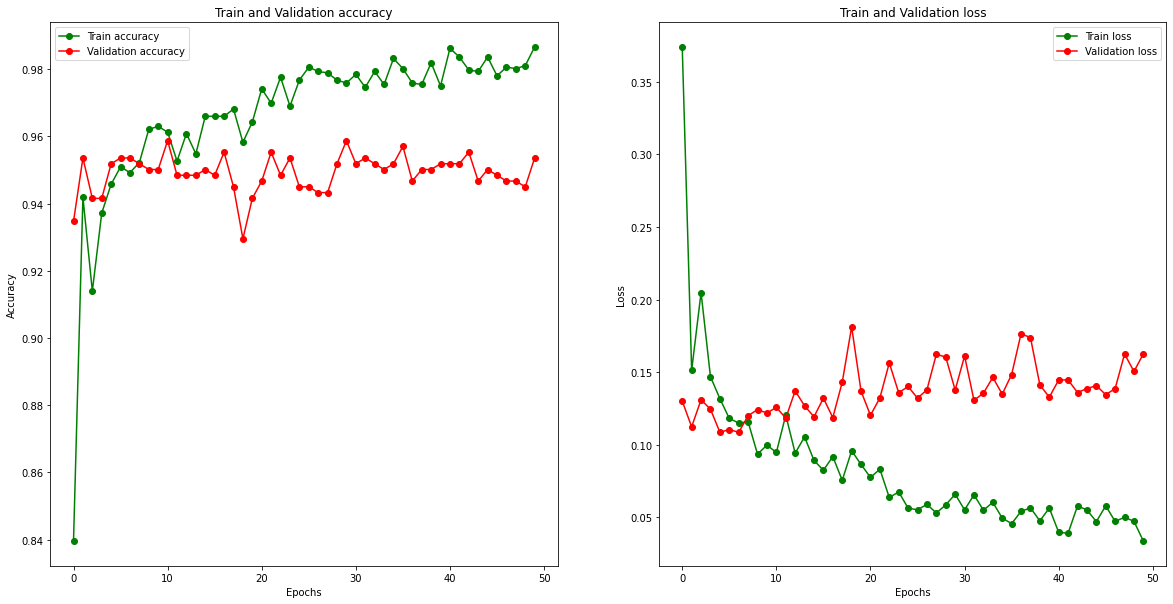

In [ ]:
# Plot the train accuracy and loss

epochs = [i for i in range(50)]

fig, ax = plt.subplots(1, 2)
train_acc = InceptionV3_history.history["accuracy"]
train_loss = InceptionV3_history.history["loss"]
val_acc = InceptionV3_history.history["val_accuracy"]
val_loss = InceptionV3_history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
# save the model to file
InceptionV3_model.save('Classification_InceptionV3_model.h5')

In [ ]:
#Use the validation dataset to test the model
test_ds = tensorflow.keras.utils.image_dataset_from_directory(
  './validation_data',
  validation_split=None,
  seed=123,
  image_size=(WIDTH, HEIGHT),
  batch_size=64)

Found 985 files belonging to 2 classes.


In [ ]:
#Get model accuracy
AUTOTUNE = tensorflow.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
loss, accuracy = InceptionV3_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

16/16 [==============================] - 2s 70ms/step - loss: 33.2979 - accuracy: 0.5076
Test accuracy : 0.5076141953468323


#### Pytorch ResNet 18



The following model built on Pytorch using the transfer learning model, ResNet18 is according to the notebook:  https://www.kaggle.com/code/azi192012/dog-vs-cat-pytorch-resnet18-99-8/notebook

In [30]:
import torch, torchvision
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import copy
import numpy as np
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import requests
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
import time


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
train_dir = '/content/drive/MyDrive/training_data/'
test_dir = '/content/drive/MyDrive/test_data/'
NUM_BATCH = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
# Transformers
transform = transforms.Compose([
    ToTensor(),
    Resize((500,500))
])

In [33]:
# Datset & DataLoader
class CatDogDataset(Dataset):

    def __init__(self, train_dir, transform = None):
        
        self.train_dir = train_dir
        self.transform = transform
        self.images = os.listdir(train_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.train_dir, self.images[index])
        label = self.images[index].split(".")[0]

        label = 0 if label == 'cat' else 1
        
        image = np.array(Image.open(image_path))
        
        if self.transform is not None:
            image = self.transform(image).to(DEVICE)
        return image, label

In [34]:
# Split training data to train and validation datasets
train_data = CatDogDataset(train_dir, transform)
train_dl = DataLoader(train_data, batch_size=NUM_BATCH)
train_data, validation_data = torch.utils.data.random_split(train_data, [2700,207], generator = torch.Generator().manual_seed(123))
val_dl = DataLoader(validation_data, batch_size= NUM_BATCH)

# Loading test data for later validating the model
test_data = CatDogDataset(test_dir, transform)
test_dl = DataLoader(test_data, batch_size=NUM_BATCH)

In [ ]:
# Using ResNet18 transfer learning model
model = torchvision.models.resnet18(pretrained=True)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

# Finetune the last fully connected layer to prefered output
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=2),
    nn.Softmax(dim=1)])

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(DEVICE)

In [44]:
# Training function
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

def train(num_epoch = EPOCHS, lr = LEARNING_RATE, device = DEVICE):
    accuracies = []
    cnn = model.to(DEVICE)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)

    max_accuracy = 0

    for epoch in range(num_epoch):
        for i, (images, labels) in tqdm(enumerate(train_dl)):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy = float(validate(cnn,val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("saving best model with accuracy: ", accuracy)
        print("Epoch: ", epoch+1, "Accuracy: ", accuracy, "%")

        train_logs['loss'].append(loss)
        train_logs['accuracy'].append(accuracy)
        
    return best_model

# Validation function

def validate(model, data):
    total = 0
    correct = 0

    for (images, labels) in data:
        images = images.to(DEVICE)
        x = model(images)

        _, pred = torch.max(x,1)
        total += x.size(0)
        correct += torch.sum(pred == labels).to(DEVICE)

    # val_logs["loss"].append(epoch_loss)
    # val_logs["accuracy"].append(epoch_acc)

    return correct*100/total

In [45]:
# Training the model
resnet = train()

# Saving the best model
torch.save(resnet.state_dict(), "/content/drive/MyDrive/Resnet18_CatDog.pth")

91it [02:04,  1.36s/it]


saving best model with accuracy:  85.02415466308594
Epoch:  1 Accuracy:  85.02415466308594 %


91it [02:03,  1.36s/it]


saving best model with accuracy:  85.99034118652344
Epoch:  2 Accuracy:  85.99034118652344 %


91it [02:03,  1.35s/it]


Epoch:  3 Accuracy:  85.99034118652344 %


91it [02:01,  1.34s/it]


saving best model with accuracy:  86.47342681884766
Epoch:  4 Accuracy:  86.47342681884766 %


91it [02:10,  1.43s/it]


Epoch:  5 Accuracy:  86.47342681884766 %


91it [02:11,  1.45s/it]


saving best model with accuracy:  86.9565200805664
Epoch:  6 Accuracy:  86.9565200805664 %


91it [02:05,  1.38s/it]


saving best model with accuracy:  87.43961334228516
Epoch:  7 Accuracy:  87.43961334228516 %


91it [02:03,  1.36s/it]


saving best model with accuracy:  87.9227066040039
Epoch:  8 Accuracy:  87.9227066040039 %


91it [02:03,  1.36s/it]


Epoch:  9 Accuracy:  87.9227066040039 %


91it [02:03,  1.36s/it]


Epoch:  10 Accuracy:  87.9227066040039 %


91it [02:08,  1.41s/it]


Epoch:  11 Accuracy:  87.9227066040039 %


91it [02:03,  1.36s/it]


saving best model with accuracy:  88.88888549804688
Epoch:  12 Accuracy:  88.88888549804688 %


91it [02:05,  1.38s/it]


Epoch:  13 Accuracy:  88.88888549804688 %


91it [02:02,  1.35s/it]


Epoch:  14 Accuracy:  88.88888549804688 %


91it [02:03,  1.35s/it]


Epoch:  15 Accuracy:  88.88888549804688 %


91it [02:02,  1.34s/it]


saving best model with accuracy:  89.37197875976562
Epoch:  16 Accuracy:  89.37197875976562 %


91it [02:03,  1.35s/it]


saving best model with accuracy:  90.33816528320312
Epoch:  17 Accuracy:  90.33816528320312 %


91it [02:03,  1.35s/it]


Epoch:  18 Accuracy:  89.85507202148438 %


91it [02:03,  1.36s/it]


Epoch:  19 Accuracy:  89.85507202148438 %


91it [02:03,  1.36s/it]


saving best model with accuracy:  90.82125854492188
Epoch:  20 Accuracy:  90.82125854492188 %


In [94]:
# Loading the best model from Pytorch ResNet18 models to test on the test data
resnet.eval()
test_accuracy = validate(resnet, test_dl)
print("The accuracy when the ResNet model was run on test data: Test Accuracy:", float(test_accuracy))

The accuracy when the ResNet model was run on test data: Test Accuracy: 92.28426361083984


# Final Best Model

In order to check whether our best training model also can accurately predict a completely new data, we fit and compare several best trained model to the test dataset. Following are several considerations why we choose AutoKeras model as our best model:

In [ ]:
TEST_IMAGE_FOLDER_PATH = "./validation_data"

FILE_NAMES = os.listdir(TEST_IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

targets=list()
full_paths=list()

for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(TEST_IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

test_dataset=pd.DataFrame()
test_dataset['image_path']=full_paths
test_dataset['target']=targets

## Best Model: AutoKeras Model

In [ ]:
# from autokeras import ImageClassifier

x_test = np.array([img_preprocess(p) for p in test_dataset['image_path'].values]) 
label = test_dataset['target']
label = np.array(label)
y_test = (label == 'cat').astype(int)

In [ ]:
# from tensorflow.keras.models import load_model

autokeras_best_model = load_model('Classification_autokeras_model.h5', custom_objects =autokeras.CUSTOM_OBJECTS)

In [ ]:
# Test model with the test data

y_pred = autokeras_best_model.predict(x_test)
y_pred = [round(y[0],0) for y in y_pred]
print("accuracy  = ", accuracy_score(y_test, y_pred))
print("recall    = ", recall_score(y_test, y_pred))
print("precision = ", precision_score(y_test, y_pred))
print("f1 score  = ", f1_score(y_test, y_pred))

accuracy  =  0.9126903553299492
recall    =  1.0
precision =  0.852233676975945
f1 score  =  0.9202226345083487


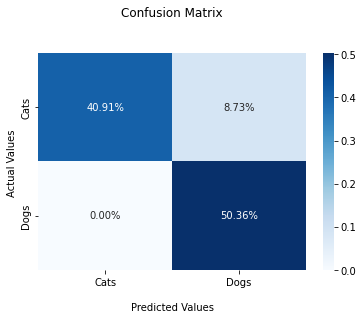

In [ ]:
cf_matrix=confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Cats','Dogs'])
ax.yaxis.set_ticklabels(['Cats','Dogs'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Conclusion

After running various models from basic CNN model to implementing data augmentation & hyperparameter tuning, then experimenting with different models such as AutoKeras, Transfer Learning, Tensorflow Keras V3 & PyTorch ResNet. We reached an accuracy of 91% with AutoKeras and therefore it is chosen to be our best performing model.

# Further Improvements

Given the time restriction, we are quite satisfied with our model and being able to achieve 92% accuracy, however, we believe that the model can be further improved. Some ideas that can be further explored that might help improving the results;

Tune Regularization. Explore minor changes to the regularization techniques used on the baseline model, such as different dropout rates and different image augmentation.
Tune Learning Rate. Explore changes to the learning algorithm used to train the baseline model, such as alternate learning rate, a learning rate schedule, or an adaptive learning rate algorithm.
Alternate Pre-Trained Model. Explore an alternate pre-trained model for transfer learning on the problem, such as VGG-16, ResNet50, Inceptionv3 orEfficientNet.
Getting more data/inventing more data by randomly modifying versions of existing data. More layers -> More nuanced model. Try out different images sizes, increase number of epochs... 
